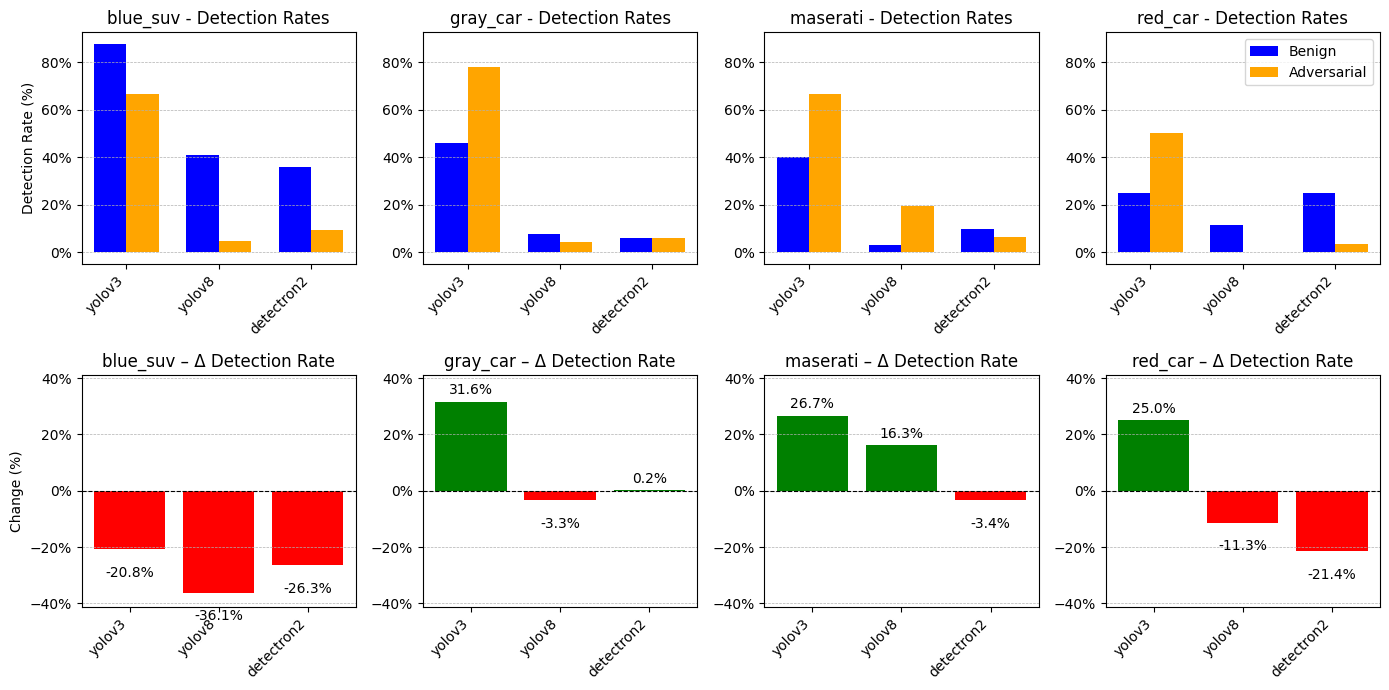

In [10]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import os

# === Step 1: Parse all render logs ===

log_path = "/raid/mhull32/3D-Gaussian-Splat-Attack/multirun/2025-04-16/18-07-37"
pattern = re.compile(r"max_iou_pred: ([\w\s]+), conf: ([\d\.]+|None)")

entries = []

for root, dirs, files in os.walk(log_path):
    if "render.log" in files:
        log_file = os.path.join(root, "render.log")
        folder = os.path.basename(root)

        scenario = "Adv" if "adv" in folder else "Benign"
        model = next((m for m in ["yolov3", "yolov8", "detectron2"] if m in folder), "unknown")
        car_type = next((c for c in ["red_car", "blue_suv", "gray_car", "maserati"] if c in folder), "unknown")

        labels, confidences = [], []
        cam_count = 0
        with open(log_file, 'r') as f:
            for line in f:
                if cam_count >= 80:
                    break
                match = pattern.search(line)
                if match:
                    label = match.group(1).strip()
                    conf = match.group(2)
                    if conf != "None":
                        labels.append(label)
                        confidences.append(float(conf))
                        cam_count += 1

        df = pd.DataFrame({"label": labels, "confidence": confidences})
        entries.append((df, model, car_type, scenario))

# === Step 2: Compute detection statistics ===

records = []
for df, model, car_type, scenario in entries:
    car_count = df["label"].value_counts().get("car", 0)
    total = len(df)
    records.append({
        "model": model,
        "car_type": car_type,
        "scenario": scenario,
        "car_detections": car_count,
        "total": total
    })

df_results = pd.DataFrame(records)
df_results["car_pct"] = 100 * df_results["car_detections"] / df_results["total"]

pivot = df_results.pivot(index=["model", "car_type"], columns="scenario", values="car_pct").reset_index()
pivot["percent_change"] = pivot["Adv"] - pivot["Benign"]

# === Setup ===

car_types = sorted(pivot["car_type"].unique())
models_order = ["yolov3", "yolov8", "detectron2"]

# Apply categorical sorting for models
pivot["model"] = pd.Categorical(pivot["model"], categories=models_order, ordered=True)
pivot_sorted = pivot.sort_values(by=["car_type", "model"])

# Determine shared y-axis limits
ymax = pivot_sorted[["Benign", "Adv"]].values.max()
ymin = pivot_sorted[["Benign", "Adv"]].values.min()
change_max = abs(pivot_sorted["percent_change"]).max()

# === Plot ===

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
bar_width = 0.35

for i, car in enumerate(car_types):
    # Filter for this car type
    df_car = pivot_sorted[pivot_sorted["car_type"] == car]

    # === Top row: Benign vs Adv detection rates ===
    ax1 = axes[0, i]
    x = np.arange(len(df_car))

    ax1.bar(x - bar_width/2, df_car["Benign"], width=bar_width, label="Benign", color='blue')
    ax1.bar(x + bar_width/2, df_car["Adv"], width=bar_width, label="Adversarial", color='orange')
    
    ax1.set_title(f"{car} - Detection Rates")
    ax1.set_ylim(ymin - 5, ymax + 5)
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_car["model"], rotation=45, ha='right')
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax1.grid(axis='y', linestyle='--', linewidth=0.5)
    if i == 0:
        ax1.set_ylabel("Detection Rate (%)")
    if i == 3:
        ax1.legend()

    # === Bottom row: Change in detection rate ===
    ax2 = axes[1, i]
    colors = ['green' if v >= 0 else 'red' for v in df_car["percent_change"]]
    bars = ax2.bar(x, df_car["percent_change"], color=colors)
    
    ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax2.set_ylim(-change_max - 5, change_max + 5)
    ax2.set_title(f"{car} – Δ Detection Rate")
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_car["model"], rotation=45, ha='right')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.grid(axis='y', linestyle='--', linewidth=0.5)
    if i == 0:
        ax2.set_ylabel("Change (%)")

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.1f}%',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3 if height >= 0 else -12),
                     textcoords="offset points",
                     ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()